<a href="https://colab.research.google.com/github/jacksontenorio8/Anti-Faude---Case-Solucion/blob/main/antifraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importação de bibliotecas

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle
from flask import Flask, request, jsonify

2. Montar Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Leitura e tratamento de dados

In [5]:
csv_path = '/content/drive/MyDrive/data/transactional-sample.csv'
df = pd.read_csv(csv_path)

# Conversão de timestamp
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Tratamento de nulos
df.fillna(0, inplace=True)

# Conversão de tipos
if 'has_cbk' in df.columns:
    df['has_cbk'] = df['has_cbk'].astype(bool)



4. Regras simples antifraude

In [6]:
def regras_simples(df):
    if 'timestamp' in df.columns:
        df['flag_muitas_transacoes'] = df.groupby('user_id')['timestamp'].transform(lambda x: x.diff().dt.total_seconds().fillna(9999) < 10)
    else:
        df['flag_muitas_transacoes'] = False
    df['flag_valor_alto'] = df['transaction_amount'] > 10000
    df['flag_estorno'] = df['has_cbk']
    df['fraude_regra'] = df[['flag_muitas_transacoes', 'flag_valor_alto', 'flag_estorno']].any(axis=1)
    return df

df = regras_simples(df)

5. Modelo Supervisionado

In [7]:
features = ['transaction_amount', 'flag_muitas_transacoes', 'flag_valor_alto', 'flag_estorno']
X = df[features].astype(float)
y = df['fraude_regra'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 260, number of negative: 1979
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 2239, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116123 -> initscore=-2.029665
[LightGBM] [Info] Start training from score -2.029665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

LGBMClassifier()

6. Avaliação do Modelo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       829
           1       1.00      1.00      1.00       131

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960

ROC AUC Score: 1.0


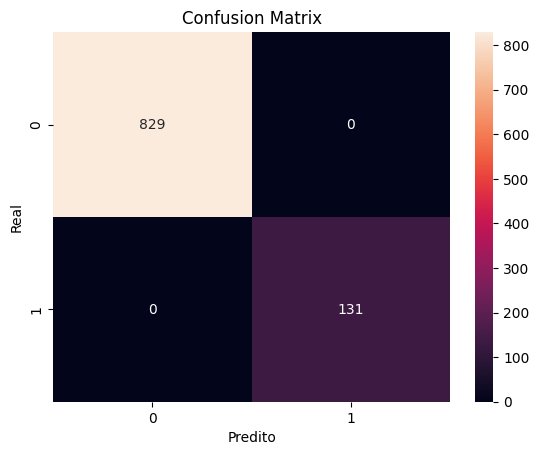

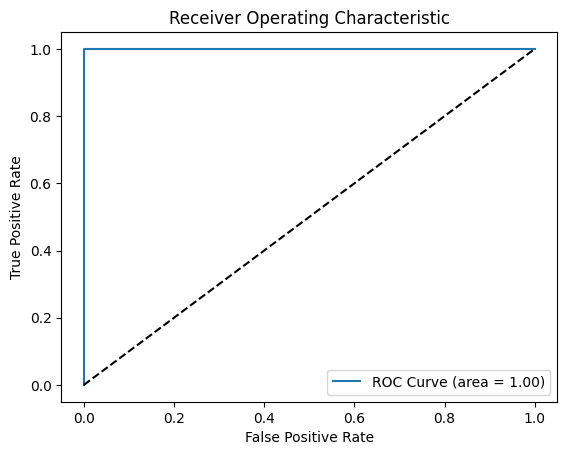

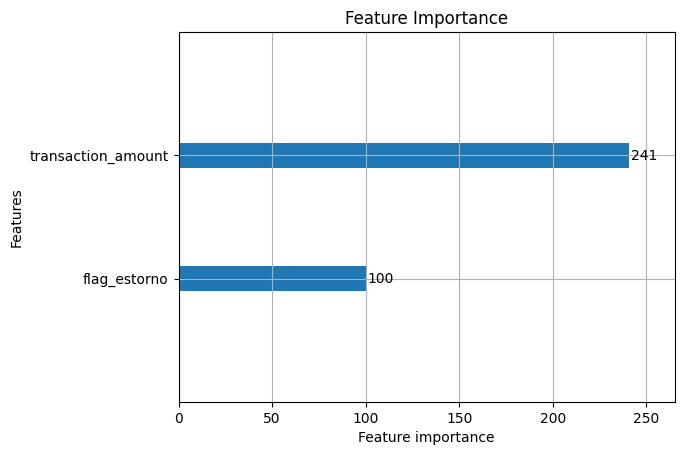

In [8]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_proba))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature importance
lgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

7. Exportação do modelo

In [9]:
with open('/content/modelo_antifraude.pkl', 'wb') as f:
    pickle.dump(model, f)

8. Endpoint RESTful (exemplo)

In [ ]:
# Este código deve ser executado localmente, não no Colab.
# from flask import Flask, request, jsonify
# app = Flask(__name__)
# @app.route('/predict', methods=['POST'])
# def predict():
#     data = request.get_json(force=True)
#     X_input = pd.DataFrame([data])
#     with open('modelo_antifraude.pkl', 'rb') as f:
#         model = pickle.load(f)
#     prediction = model.predict(X_input)[0]
#     return jsonify({'fraude': bool(prediction)})
# app.run(port=5000, debug=True)